# IMPORTS Y PACKAGES

In [100]:
#Packages to install

#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install ipywidgets

In [101]:
#Imports

import math
import time as time
import pandas as pd
import numpy as np
import scipy as sp
import random as rd
import ipywidgets as widgets
import time
from ipywidgets import HBox, VBox, interact, interact_manual,interactive
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from sklearn import preprocessing

#Interactive plot
#%matplotlib notebook
#%matplotlib inline

# CLASES

## Clases para generar y mostrar ejemplos

In [102]:
class DataSet:
    
    data = []
    points = []
    drawPoint = []
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.__read(',')
        
    #Derived
    def __read(self, sep):
        self.data = pd.read_csv(self.file_path, sep=sep,encoding='utf8')
        self.drawPoint = []
        points = []
        allX = []
        allY =[]
                
        for index, row in self.data.iterrows():
            p = Point(row['Coord X'],row['Coord Y'])
            points.append(p)
            allX.append(p.x)
            allY.append(p.y)
        
        self.points = points
        self.drawPoint.append(allX)
        self.drawPoint.append(allY)
        
        return self.points
        
    def drawData(self, drawType):       
        plt.plot(self.drawPoint[0],self.drawPoint[1],drawType)

In [103]:
class Canvas:
    
    width = 0
    height = 0
    data = []
    points = []

    def __init__(self, width, height, data):
        self.width = width
        self.height = height
        self.data = data
        self.points = self.__dataToPoints()
   
    #Derived
    def __dataToPoints(self):
        res = []        
        for i in range (0,len(self.data)):            
            for j in range(0,self.data[i].numOfPoints):                
                point=[]
                point.append(self.data[i].xVals[j])
                point.append(self.data[i].yVals[j])              
                point.append("Circulo"+str(i+1))
                
                res.append(point)
        return res
    
    def rawPoints(self,rawData):
        aux = []
        res = []
        
        for i in range (0,len(rawData)):
            
            aux.append(rawData[i].x)
            aux.append(rawData[i].y)
            
            res.append(aux)
            
            aux = []
            
        self.points = res;
    
    def drawData(self):
        for i in range (0,len(self.points)):
            plt.plot(self.points[i][0],self.points[i][1],'ro')
            
    def drawDataPlot(self):
        xs = []
        ys = []
        
        for i in range (0,len(self.points)):
            xs.append(self.points[i][0])
            ys.append(self.points[i][1])
        
        return self.data,xs,ys
    
    def removeRandomPoints(self,percentage):
        if len(self.points) != 0:
            pointsToRemove = int(len(self.points)*percentage)
            newArrayLen = len(self.points)

            for i in range (0, pointsToRemove):
                j = rd.randint(0,newArrayLen-1)
                self.points.pop(j)
                newArrayLen -= 1
        else:
            print("Data debe tener al menos un punto.")
    
    def insertNoise(self,devX,devY):
        noiseX = np.random.normal(0,devX,len(self.points))
        noiseY = np.random.normal(0,devY,len(self.points))
        
        for i in range(0,len(self.points)):
            self.points[i][0] += noiseX[i]
            self.points[i][1] += noiseY[i]
            
    def drawRandomCircunferencesRandomRadius(self,numOfCircunferences,precision):   
        for i in range (0,numOfCircunferences):
            
            maxRad = 0
            
            if(self.width > self.height):
                maxRad = self.height/2
            else:
                 maxRad = self.width/2
            
            radius = rd.uniform(1,maxRad)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)
                       
            c = Circunference(Point(centerX,centerY),radius,precision)
            self.data.append(c)
            c.draw()
        
        self.points = self.__dataToPoints()
            
    def drawRandomCircunferencesRadiusRange(self,numOfCircunferences, minRadius, maxRadius, precision):   
        for i in range (0,numOfCircunferences):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circunference(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            c.draw()
            
        self.points = self.__dataToPoints()
        
    def drawRandomCircunferencesRadiusRangePlot(self,numOfCircunferences, minRadius, maxRadius, precision):    
        for i in range (0,numOfCircunferences):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circunference(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            
        self.points = self.__dataToPoints()

## Clases del dominio del problema

In [104]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def getFurthestPoint(self,points):
        res = Point(0,0)
        auxDis = 0.0
        
        for i in range(0,len(points)):
            dis = self.calculateDistanceToPoint(points[i])
            
            if(dis>auxDis):
                auxDis = dis
                res = points[i]
            
        return res, auxDis
    
    def calculateDistanceToCluster(self,c):
        dis = self.calculateDistanceToPoint(c.center)
        return abs(dis - c.radius)
    
    def calculateDistanceToCluster_noAbs(self,c):
        dis = self.calculateDistanceToPoint(c.center)
        return dis - c.radius
    
    def calculateThreshold(self,circles):
        distances = []
        distances_n = []
        
        for i in range(0,len(circles)):
            distances.append(self.calculateDistanceToCluster(circles[i]))
                
        mod = 0.000000000000000000001
        for i in range(0,len(distances)):
            mod += distances[i]
            
        distances_n = abs(mod - np.array(distances))*(1/mod)
        
        return distances_n
    
    def calculatePerpendicular(self,p):
        precision = 0.000001
        
        #Punto medio
        xMean = (self.x + p.x)/2
        yMean = (self.y + p.y)/2
        
        if(p.y - self.y == 0):
            self.y += precision
        
        if(p.x - self.x == 0):
            self.x += precision
        
        #Pendiente usando: y - y1 = m(x - x1) y  mp = -1/m
        m = -1/((p.y - self.y)/(p.x - self.x))
        
        #Se devuelve [x,y,b]
        perpendicular = ([-m,1,m*(-xMean)+yMean])
        
        return perpendicular
    
    def calculateDistanceToPoint(self,p):
        disX = p.x - self.x
        disY = p.y - self.y
        dis = math.sqrt(disX*disX + disY*disY)
        
        return dis
    
    def equals(self,p):
        if(self.x == p.x and self.y == p.y):
            return 1
        else:
            return 0
        
    def print(self):
        print("(",self.x,",",self.y,")")

In [105]:
class Circunference:
    
    center = 0
    radius = 0
    numOfPoints = 0
    xVals = []
    yVals = []
    
    def __init__(self, center, radius, numOfPoints):
        self.center = center
        self.radius = radius
        self.numOfPoints = numOfPoints
        self.__calculate()
      
    #Derived
    def __calculate(self):
        self.xVals = []
        self.yVals = []
        
        alpha = 2*math.pi/self.numOfPoints
        i = 0     
        while i < 2*math.pi:
            self.xVals.append(self.center.x + self.radius*math.cos(i))
            self.yVals.append(self.center.y + self.radius*math.sin(i))
            i += alpha
            
    def update(self, center, radius):
        self.center = center
        self.radius = radius
        self.__calculate()
    
    def draw(self):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            plt.plot(xPrimeVals,yPrimeVals)
            plt.plot(self.center.x,self.center.y,'bo')
    
    def drawPlot(self):
        fig = plt.figure('fig')
        ax = fig.add_subplot(111)
                
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            ax.plot(xPrimeVals,yPrimeVals)
            ax.plot(self.center.x,self.center.y,'bo')
            
            return fig,ax
            
    def drawSubplot(self,axs,it):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            axs[it].plot(xPrimeVals,yPrimeVals)
            axs[it].plot(self.center.x,self.center.y,'bo')
                 
    def calculateWithCircumcenter(points):
        radius = -1
        while radius == -1:
        
            randomPoints = rd.sample(points,3)
            p1,p2,p3 = randomPoints[0],randomPoints[1],randomPoints[2]
        
            #Mediatrices
            perp1 = p1.calculatePerpendicular(p2)
            perp2 = p1.calculatePerpendicular(p3)

            A = [[perp1[0],perp1[1]],[perp2[0],perp2[1]]]

            #Circuncentro
            if(np.linalg.det(A)==0):
                return Point(0,0),-1
            else:
                B = [[perp1[2]],[perp2[2]]]
                X = np.linalg.solve(A,B)
                circumcenter = Point(X[0],X[1])

                #Radio
                radius = circumcenter.calculateDistanceToPoint(p1)

                return circumcenter, radius
        
    def calculateWithBarycentre(list_points):
        sumX = 0
        sumY = 0
        radius = 0
        
        for i in range(0,len(list_points)):
            sumX = sumX + list_points[i].x
            sumY = sumY + list_points[i].y
        
        center = Point(sumX/len(list_points),sumY/len(list_points))
        
        for i in range(0,len(list_points)):
            radius = radius + center.calculateDistanceToPoint(list_points[i])
        
        radius = radius/len(list_points)
        
        return center,radius

## Clases del algoritmo

In [106]:
class ClusteringSolver:
    
    clustersNumber = 0
    points = []
    
    clusters = []
    threshold = []
    
    sol_clusters = []
    sol_threshold = []
    
    def __init__(self,filePath,clustersNumber):
        self.clustersNumber = clustersNumber
        self.points = DataSet(filePath).points
        
        self.clusters = []
                    
    def initRandomClusters(self):
        initialClusters = []
            
        for i in range(0,self.clustersNumber):
            
            indexOfRandomPoint = rd.randint(0,len(self.points)-1)
            randomPoint = self.points[indexOfRandomPoint]
            randomRadius = rd.uniform(1,10)

            cluster = Circunference(randomPoint,randomRadius,20)            
            initialClusters.append(cluster)

        self.clusters = initialClusters
    
    def calculateThreshold(self):
        threshold = []
        
        for i in range(0,len(self.points)):
            point = self.points[i]
            threshold.append(point.calculateThreshold(self.clusters))
        
        return threshold
       
    def getClustersAssignment(self,threshold):
        clustersAssignment = []  
        
        for i in range(0,len(threshold)):
            tuplePointCluster = []
            clusterIndex = 0
            thresholdVal = 0
            point = Point(0,0)
            
            for j in range(0,len(threshold[i])):
                if(j==0):
                    thresholdVal = threshold[i][j]
                    point = self.points[i]
                    clusterIndex = j
                else:
                    if(threshold[i][j] > thresholdVal):
                        thresholdVal = threshold[i][j]
                        point = self.points[i]
                        clusterIndex = j
                        
            tuplePointCluster.append(point)
            tuplePointCluster.append(clusterIndex)
            clustersAssignment.append(tuplePointCluster)
            
            tuplePointCluster = []
            clusterIndex = 0
            point = Point(0,0)
            thresholdVal = 0
    
        return clustersAssignment
    
    def groupPointsByCluster(self,clustersAssignment):
        
        pointsGroupedByCluster = []
        
        for k in range(0,len(self.clusters)):
                                       
            cluster = []

            for z in range(0,len(clustersAssignment)):

                if(k == clustersAssignment[z][1]):
                    point = Point(clustersAssignment[z][0].x,clustersAssignment[z][0].y)
                    cluster.append(point)

            pointsGroupedByCluster.append(cluster)
        
        return pointsGroupedByCluster
    
    def calculateCluster(self,mode,points):
        if len(points) == 0:
            center = Point(0,0)
            radius = -1
        else:
            if mode == 'c' and len(points)>2:            
                center, radius = Circunference.calculateWithCircumcenter(points)        
            else:
                center, radius = Circunference.calculateWithBarycentre(points)  
        
        return center, radius
        
    def learn(self,generations,precision,limit,mode):
        
        initTime = time.process_time()
        
        generationNumber = 0
        generationClusters = []
        generationAssignment = []    
        generationDist = 0       

        while generationNumber < generations:
        
            self.initRandomClusters()
            
            keepIterating = 1
            previousIteration = []
            
            limIt = 0
            while keepIterating == 1:
                            
                previousIteration = deepcopy(self.clusters)
                                
                self.threshold = self.calculateThreshold()
                clustersAssignment = self.getClustersAssignment(self.threshold)
                pointsGroupedByCluster = self.groupPointsByCluster(clustersAssignment)
                
                dirtyGen = 0
                for k in range(0,len(pointsGroupedByCluster)):
                    center,radius = self.calculateCluster(mode,pointsGroupedByCluster[k])
                    
                    if radius == -1:
                        generationNumber -= 1
                        dirtyGen = 1
                        break
                        
                    self.clusters[k].update(center,radius)
            
                if dirtyGen == 1:
                    break
                             
                dirtyIt = 0
                for j in range(0,len(previousIteration)):
                    
                    prevCenter = previousIteration[j].center
                    prevRadius = previousIteration[j].radius
                    
                    actualCenter = self.clusters[j].center
                    actualRadius = self.clusters[j].radius
                    
                    centerCond = prevCenter.calculateDistanceToPoint(actualCenter) > precision
                    radiusCond = abs(prevRadius - actualRadius) > precision

                    if centerCond or radiusCond:
                        dirtyIt = 1
                
                if(dirtyIt == 0 or limIt == limit):                   
                    keepIterating = 0       
                
                limIt += 1
            
            if generationNumber <= 0:
                generationClusters = self.clusters
                generationAssignment = clustersAssignment
                
                for j in range(0,len(generationAssignment)):
                    generationDist += generationAssignment[j][0].calculateDistanceToCluster(generationClusters[generationAssignment[j][1]])
            else:
                tempClusters = self.clusters
                tempAssignment = clustersAssignment
                dist = 0
                for j in range(0,len(tempAssignment)):
                    dist += tempAssignment[j][0].calculateDistanceToCluster(tempClusters[tempAssignment[j][1]])
                
                if(dist < generationDist):
                    generationClusters = tempClusters
                    generationAssignment = tempAssignment
                    generationDist = dist
            
            generationNumber += 1
        
        self.sol_clusters = generationClusters
        self.sol_threshold = generationAssignment
        
        print("Elapsed time: ",time.process_time()-initTime)

In [107]:
class Solution:
    
    clusteringSolver = 0
    finalClusters = []
    finalAssignment = []
    
    def __init__(self, clusteringSolver):
        self.clusteringSolver = clusteringSolver
        self.finalClusters = self.clusteringSolver.sol_clusters
        self.finalAssignment = self.clusteringSolver.sol_threshold
       
    def eraseNoise(self,minThreshold):
        pointsToErase = []
        
        for i in range(len(self.finalAssignment)-1,-1,-1):
            
            threshold = self.finalAssignment[i][0].calculateThreshold(self.finalClusters)
            
            if(threshold[self.finalAssignment[i][1]] < minThreshold):
                pointsToErase.append(i)
        
        for i in range(0,len(pointsToErase)):
            self.finalAssignment.pop(pointsToErase[i])
        
        print("Min Threshold: ",minThreshold)
        print("Erased Points: ",len(pointsToErase))
        
    def drawSolution(self,minThreshold):
        self.eraseNoise(minThreshold)
        
        for i in range (0,len(self.finalClusters)):
            self.finalClusters[i].draw()

        for i in range(0,len(self.finalAssignment)):
            if(self.finalAssignment[i][1] == 0):
                plt.plot(self.finalAssignment[i][0].x,self.finalAssignment[i][0].y,'go')
            elif(self.finalAssignment[i][1] == 1):
                plt.plot(self.finalAssignment[i][0].x,self.finalAssignment[i][0].y,'ko')
            elif(self.finalAssignment[i][1] == 2):
                plt.plot(self.finalAssignment[i][0].x,self.finalAssignment[i][0].y,'ro')
            elif(self.finalAssignment[i][1] == 3):
                plt.plot(self.finalAssignment[i][0].x,self.finalAssignment[i][0].y,'co')
            elif(self.finalAssignment[i][1] == 4):
                plt.plot(self.finalAssignment[i][0].x,self.finalAssignment[i][0].y,'mo')
            else:
                plt.plot(self.finalAssignment[i][0].x,self.finalAssignment[i][0].y,'yo')
                

## Clases de interfaz

In [108]:
class ClusteringUI():
    
    canvasCC = Canvas(100,100,[])
    canvasLoad = Canvas(100,100,[])
            
    def createAndSolve(self):
        
        filePath = widgets.Text(
            value='',
            placeholder='C:..',
            description='File path to be saved:',
            disabled=False,
            style = {'description_width': 'initial'}
        )

        numCircles = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 10,
            description = 'Circunference Num.:',
            orientation = 'horizontal',
            style = {'description_width': 'initial'}
        )
                
        numCirclesSol = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 10,
            description = 'Cluster Num.:',
            orientation = 'horizontal',
            style = {'description_width': 'initial'}
        )

        rangeRadius = widgets.IntRangeSlider(
            value = [5,10],
            min = 1,
            max = 10,
            description = 'Circunference Radius:',
            orientation = 'horizontal',
            style = {'description_width': 'initial'}
        )

        circlePrecision = widgets.IntSlider(
            value = 20,
            min = 1,
            max = 20,
            description = 'Circunference Precision:',
            orientation = 'horizontal',
            style = {'description_width': 'initial'}
        )

        removePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1,
            step = 0.1,
            description = 'Remove %:',
            orientation = 'horizontal'
        )

        noisePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1.5,
            step = 0.1,
            description = 'Noise:',
            orientation = 'horizontal'
        )

        genNumber = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 500,
            description = 'Generations:',
            orientation = 'horizontal'
        )
        
        precisionSolver = widgets.SelectionSlider(
            options=[0.001, 0.01, 0.1, 1],
            value=0.001,
            description='Precision:',
            disabled=False,
            orientation='horizontal',
        )

        maxLimitIt = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 50,
            description = 'Max. It.:',
            orientation = 'horizontal'
        )

        mode = widgets.SelectMultiple(
            options=['b','c'],
            value=['b'],
            description='Mode',
            disabled=False
        )

        noiseReduction = widgets.FloatSlider(
            value = 0.1,
            min = 0.750,
            max = 1,
            step = 0.001,
            readout_format='.3f',
            description = 'Min. Threshold:',
            orientation = 'horizontal',
            style = {'description_width': 'initial'}
        )
                
        @interact_manual(nc=numCircles,rd=rangeRadius,cp=circlePrecision)
        def generate(nc,rd,cp):

            global canvasCC
            plt.figure(2)

            canvas = Canvas(100,100,[])
            canvas.drawRandomCircunferencesRadiusRangePlot(nc,rd[0],rd[1],cp)

            canvasCC = deepcopy(canvas)

            clusters,xs,ys = canvas.drawDataPlot()

            for i in range(0,len(clusters)):
                clusters[i].draw()

            plt.plot(xs,ys,'ro')
            plt.show()

        @interact_manual(fp=filePath,rp=removePercentage,nop=noisePercentage)
        def edit(fp,rp,nop):
            plt.figure(2)

            edit_canvas = deepcopy(canvasCC)
            edit_canvas.removeRandomPoints(rp)
            edit_canvas.insertNoise(nop,nop)

            clusters,xs,ys = edit_canvas.drawDataPlot()

            for i in range(0,len(clusters)):
                clusters[i].draw()

            plt.plot(xs,ys,'ro')
            plt.show()

            file_path_ex = fp
            headers = ['Coord X','Coord Y', 'Circulo']
            df = pd.DataFrame(edit_canvas.points, columns= headers)
            df = df.sample(frac=1)
            df.to_csv(file_path_ex, columns=headers, index=False, encoding="utf8")

            setData = DataSet(file_path_ex)

        @interact_manual(gn=genNumber,nc=numCirclesSol,p=precisionSolver,mxL=maxLimitIt,m=mode,nr=noiseReduction)
        def solve(gn,nc,p,mxL,m,nr):
            file_path_ex = filePath.value
            csExample = ClusteringSolver(file_path_ex,nc)
            csExample.learn(gn,p,mxL,m[0])
            solEx = Solution(csExample)
            solEx.drawSolution(nr)
            
    def loadAndSolve(self):
        
        filePath = widgets.Text(
            value='',
            placeholder='C:..',
            description='File Path to load:',
            disabled=False,
            style = {'description_width': 'initial'}
        )
        
        """
        filePath2 = widgets.Text(
            value='',
            placeholder='C:..',
            description='File Path to be saved:',
            disabled=False,
            style = {'description_width': 'initial'}
        )
        """
        
        numCircles = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 10,
            description = 'Cluster Num.:',
            orientation = 'horizontal'
        )
        
        genNumber = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 500,
            description = 'Generations:',
            orientation = 'horizontal'
        )

        precisionSolver = widgets.SelectionSlider(
            options=[0.001, 0.01, 0.1, 1],
            value=0.001,
            description='Precision:',
            disabled=False,
            orientation='horizontal',
        )

        maxLimitIt = widgets.IntSlider(
            value = 1,
            min = 1,
            max = 50,
            description = 'Max. It.:',
            orientation = 'horizontal'
        )

        mode = widgets.SelectMultiple(
            options=['b','c'],
            value=['b'],
            description='Mode',
            disabled=False
        )

        noiseReduction = widgets.FloatSlider(
            value = 0.1,
            min = 0.750,
            max = 1,
            step = 0.001,
            readout_format='.3f',
            description = 'Min. Threshold:',
            orientation = 'horizontal',
            style = {'description_width': 'initial'}
        )
        
        removePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1,
            step = 0.1,
            description = 'Remove %:',
            orientation = 'horizontal'
        )

        noisePercentage = widgets.FloatSlider(
            value = 0.1,
            min = 0,
            max = 1.5,
            step = 0.1,
            description = 'Noise %:',
            orientation = 'horizontal'
        )
        
        @interact_manual(fp=filePath)
        def load(fp):
            
            setData = DataSet(fp)
            
            global canvasLoad
            canvas = Canvas(100,100,[])
            canvas.rawPoints(setData.points)
            canvasLoad = deepcopy(canvas)
            
            setData.drawData('ro')
        
        """
        Método para editar las imagenes que se cargar.
        
        @interact_manual(fp=filePath2,rp=removePercentage,nop=noisePercentage)
        def edit_load(fp,rp,nop):
            plt.figure(2)

            edit_canvas = deepcopy(canvasLoad)
            edit_canvas.removeRandomPoints(rp)
            edit_canvas.insertNoise(nop,nop)

            clusters,xs,ys = edit_canvas.drawDataPlot()

            for i in range(0,len(clusters)):
                clusters[i].draw()

            plt.plot(xs,ys,'ro')
            plt.show()

            file_path_ex = fp
            headers = ['Coord X','Coord Y']
            df = pd.DataFrame(edit_canvas.points, columns= headers)
            df = df.sample(frac=1)
            df.to_csv(file_path_ex, columns=headers, index=False, encoding="utf8")

            setData = DataSet(file_path_ex)
        """
        
        @interact_manual(gn=genNumber, nc=numCircles,p=precisionSolver,mxL=maxLimitIt,m=mode,nr=noiseReduction)
        def solve_load(gn,nc,p,mxL,m,nr):
            
            file_path_ex = filePath.value         
            csExample = ClusteringSolver(file_path_ex,nc)
            csExample.learn(gn,p,mxL,m[0])
            solEx = Solution(csExample)
            solEx.drawSolution(nr)

# EJEMPLOS
## Generador de Ejemplos
### Generamos un Canvas de ejemplo y una copia de este
<ol>
<li>Instanciamos un objeto Canvas indicando sus proporciones.</li>
<li>Generamos un ejemplo aleatorio. Se debe proporcionar número de circunferencias, rango inferior y superior para el radio, y número de puntos de dichas circunferencias.</li>
<li>Mostramos el ejemplo creado.</li>
</ol>

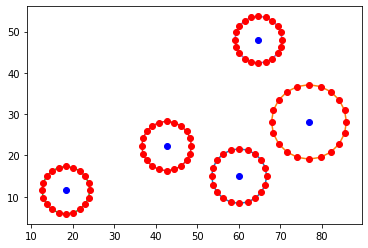

In [109]:
canvas = Canvas(100,100,[])
canvas.drawRandomCircunferencesRadiusRange(5,5,10,20)
canvas.drawData()

### Duplicación de copia y edición de esta
<ol>
<li>Creamos una copia del ejemplo generado para poder modificarlo sin afectar al original.</li>
<li>Eliminamos un porcentaje de puntos.</li>
<li>Insertamos ruido para ambas coordenadas.</li>
<li>Mostramos el ejemplo modificado.</li>
</ol>

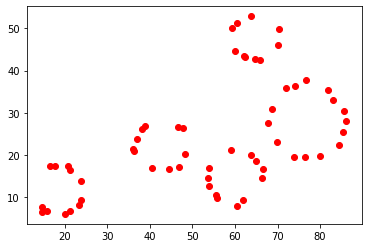

In [110]:
canvasCopy = deepcopy(canvas)
canvasCopy.removeRandomPoints(0.4)
canvasCopy.insertNoise(0.4,0.4)
canvasCopy.drawData()

### Guardamos el Canvas en un archivo .csv


In [111]:
file_path_ex = r"Datos/canvas_export.csv"
headers = ['Coord X','Coord Y', 'Circulo']
df = pd.DataFrame(canvasCopy.points, columns= headers)
df = df.sample(frac=1)
df.to_csv(file_path_ex, columns=headers, index=False, encoding="utf8")

### Convertimos el archivo .csv en un DataSet y comprobamos que los datos son correctos

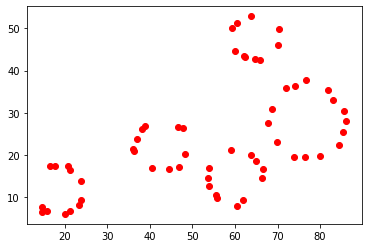

In [112]:
setData = DataSet(file_path_ex)
setData.drawData('ro')

### Ejecutamos el algoritmo y mostramos la solución
<ol>
<li>Instanciamos un objeto ClusteringSolver con la ruta al archivo .csv creado y el número de clusters.</li>
<li>Ejecutamos el algoritmo. Debemos proporcionar número de generaciones, precisión, número máximo de iteraciones y método para el cálculo de las circunferencias (c = Circuncentro, b = Baricentro)</li>
<li>Instanciamos un objeto Solution con el resultado del algoritmo. Debemos proporcionar un objeto Clustering Solver</li>
<li>Mostramos la solución eliminando el ruido que deseemos. Debemos proporcionar el mínimo grado de pertenencia que no consideramos ruido.</li>
</ol>

Elapsed time:  6.75
Min Threshold:  0.8
Erased Points:  0


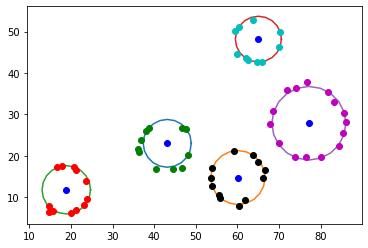

In [113]:
csExample = ClusteringSolver(file_path_ex,5)
csExample.learn(50,0.01,30,'c')
solEx = Solution(csExample)
solEx.drawSolution(0.8)

## Carga de ejemplos
### Carga de datos
<ol>
<li>Instanciamos un objeto DataSet con la ruta al archivo .csv con el ejemplo.</li>
<li>Mostramos el ejemplo.</li>
</ol>

### Resolución
<ol>
<li>Instanciamos un objeto ClusteringSolver con la ruta al archivo .csv creado y el número de clusters.</li>
<li>Ejecutamos el algoritmo. Debemos proporcionar número de generaciones, precisión, número máximo de iteraciones y método para el cálculo de las circunferencias (c = Circuncentro, b = Baricentro)</li>
<li>Instanciamos un objeto Solution con el resultado del algoritmo. Debemos proporcionar un objeto Clustering Solver</li>
<li>Mostramos la solución eliminando el ruido que deseemos. Debemos proporcionar el mínimo grado de pertenencia que no consideramos ruido.</li>
</ol>

### Ejemplo 1 aportado por el tutor
#### Carga de datos

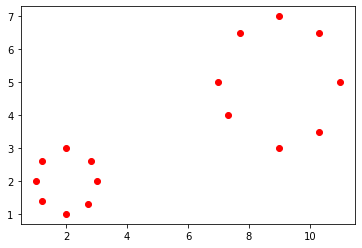

In [114]:
file_path1 = r"Datos/DatosPrueba/datos_prueba_1.csv"
setData = DataSet(file_path1)
setData.drawData('ro')

#### Resolución

Elapsed time:  0.265625
Min Threshold:  0.99
Erased Points:  0


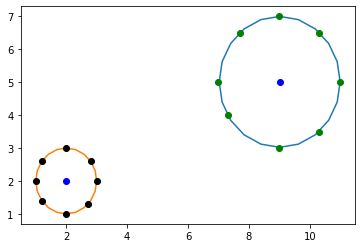

In [115]:
cs1 = ClusteringSolver(file_path1,2)
cs1.learn(10,0.01,50,'c')
sol1 = Solution(cs1)
sol1.drawSolution(0.99)

### Ejemplo 2 aportado por el tutor
#### Carga de datos

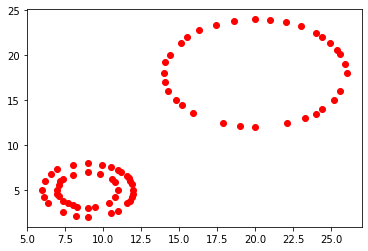

In [116]:
file_path2 = r"C:Datos/DatosPrueba/datos_prueba_2.csv"
setData = DataSet(file_path2)
setData.drawData('ro')

#### Resolución

Elapsed time:  5.984375
Min Threshold:  0.95
Erased Points:  0


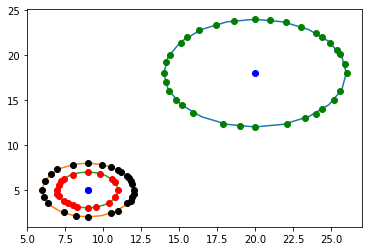

In [117]:
cs2 = ClusteringSolver(file_path2,3)
cs2.learn(50,0.01,30,'c')
sol2 = Solution(cs2)
sol2.drawSolution(0.95)

## Interfaz de usuario
### Generación y resolución de ejemplos

In [118]:
UI = ClusteringUI()
UI.createAndSolve()

interactive(children=(IntSlider(value=1, description='Circunference Num.:', max=10, min=1, style=SliderStyle(d…

interactive(children=(Text(value='', description='File path to be saved:', placeholder='C:..', style=Descripti…

interactive(children=(IntSlider(value=1, description='Generations:', max=500, min=1), IntSlider(value=1, descr…

### Carga y resolución de ejemplos

In [119]:
UI2 = ClusteringUI()
UI2.loadAndSolve()

interactive(children=(Text(value='', description='File Path to load:', placeholder='C:..', style=DescriptionSt…

interactive(children=(IntSlider(value=1, description='Generations:', max=500, min=1), IntSlider(value=1, descr…

# Código descartado

## Versión iterativa del algoritmo

In [18]:
"""def learn_it(self,generations,iterations,mode):
        
        generation_cluster = []
        auxThreshold = []
        auxDist = 0
        
        count = 0
        while count < generations:
            #Initilization
            self.initRandomCluster()
        
            for j in range(0,iterations):
                                
                data_to_cluster = []
                data = self.calculateThreshold()
                            
                for k in range(0,len(self.clusters)):
                                       
                    cluster = []
                           
                    for z in range(0,len(data)):
                                                
                        if(k == data[z][1]):
                            p = Point(data[z][0].x,data[z][0].y)
                            cluster.append(p)
                           
                    data_to_cluster.append(cluster)
                
                dirty = 0
                for k in range(0,len(data_to_cluster)):
                    
                    c,r = self.calculateCircunference(mode,data_to_cluster[k])
        
                    if r == -1:
                        count -= 1
                        dirty = 1
                        break
                        
                    self.clusters[k].update(c,r)     
            
                if dirty == 1:
                    break
            
            #Check Best Generation
            if count <= 0:
                generation_cluster = self.clusters
                auxThreshold = data
                
                for j in range(0,len(auxThreshold)):
                    auxDist += auxThreshold[j][0].calculateDistanceToCluster(generation_cluster[auxThreshold[j][1]])
            else:
                temp_cluster = self.clusters
                temp_threshold = data
                dist = 0
                for j in range(0,len(temp_threshold)):
                    dist += temp_threshold[j][0].calculateDistanceToCluster(temp_cluster[temp_threshold[j][1]])
                
                if(dist < auxDist):
                    generation_cluster = temp_cluster
                    auxThreshold = temp_threshold
                    auxDist = dist                    
            
            count += 1
        
        return generation_cluster,auxThreshold"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-18-87f751064139>, line 65)

## Selección de puntos para el circuncentro

In [ ]:
"""def CalculateBestFitPoints1(self,listOfPoints):     
        
        sumX = 0.0
        sumY = 0.0
        distance = 0.0
        auxPoint = []
        auxCenter = 0 
        
        for i in range(0,len(listOfPoints)):
            
            #furthests point from points        
            for j in range(0,len(listOfPoints)):
                actDistance = math.sqrt(pow(listOfPoints[j].x-listOfPoints[i].x,2)+pow(listOfPoints[j].y-listOfPoints[i].y,2))
                if(actDistance > distance):
                    distance = actDistance
                    auxPoint = [listOfPoints[i],listOfPoints[j]]
            
            sumX += listOfPoints[i].x
            sumY += listOfPoints[i].y
        
        p = Point(sumX/len(listOfPoints),sumY/len(listOfPoints))
        
        vecL = Point((auxPoint[0].x+auxPoint[1].x)/2,(auxPoint[0].y+auxPoint[1].y)/2)
    
        newVec = Point(p.x-vecL.x,p.y - vecL.y)
        rect = Point(newVec.y, -newVec.x)
        c = -(rect.x * p.x + rect.y * p.y)
        
        auxVal = 10
        closestPoint = 0
        for j in range(0,len(listOfPoints)):
            
            val = abs(rect.x * listOfPoints[j].x + rect.y * listOfPoints[j].y + c)
            if(j == 0):
                auxVal = val
            else:
                if(val < auxVal):
                    auxVal = val
                    closestPoint = listOfPoints[j]
        
       
        plt.plot(auxPoint[0].x,auxPoint[0].y,'go')
        plt.plot(closestPoint.x,closestPoint.y,'go')
        plt.plot(auxPoint[1].x,auxPoint[1].y,'go')
        
        return p,auxPoint"""

In [14]:
"""def calculateBestFitPoints2(self,listOfPoints):     
       
        #first random point
        p1 = rd.randint(0,len(listOfPoints)-1)
        
        #furthest point
        dis = 0.0
        p2 = 0
        for i in range(0,len(listOfPoints)):
            if(i != p1):
                aux_dis = listOfPoints[p1].calculateDistanceToPoint(listOfPoints[i])
                
                if(aux_dis > dis):
                    dis = aux_dis
                    p2 = i
                            
        p3 = p1
        while p3 == p1 or p3 == p2:
            p3 = rd.randint(0,len(listOfPoints)-1)  
        
        return listOfPoints[p1],listOfPoints[p2],listOfPoints[p3]"""